<a href="https://colab.research.google.com/github/PetchMa/deeplearning_fundamentals/blob/main/Neural_ODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build Neural Ordinary Differential Equations

Neural ODE's are a new approach to making neural networks continous... Okay so basically we know that neural networks have a discrete number of layers. We also see that theres a special kind of layer called residual neural networks. These residual neural networks basically takes the output of the layer and adds the original input back to the output. Thus allowing the neural network to decide on its own how deep it can be. This is because if the neural network can learn all the parameters of the network to just be 0 which would effectively skip the layer. 

Why is this useful? Because you realize quickly that this formula for the resnet which is $$l_{n+1} = l_{n}+ f(l_n)$$ which is if you've ever worked with Ordinary differential equations is almost the EXACT FORM as the euler differential equation which is 
$$x(t+h) = x(t) + hx'(t)$$$
However we know how to solve these kinds of ordinary differential equations! We can solve for $$x$$ generally for any given input. Solving this would give the general definition for the neural net as a numerical approximation to the function. 
 
Here are some good notes documenting this approach
[link](http://implicit-layers-tutorial.org/neural_odes/)


In [9]:
import jax.numpy as jnp
from jax.nn import relu
from jax import jit, grad
from jax import value_and_grad, vmap
import jax
from jax.scipy.special import logsumexp
import numpy as np
import matplotlib.pyplot as plt

seed = 0

def init_MLP(layer_widths,parent_key, scale =0.01):
  params = []
  keys = jax.random.split(parent_key,num=len(layer_widths)-1)
  for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
    weight_key, bias_key = jax.random.split(key)

    params.append(
                   [scale*jax.random.normal(weight_key, shape=(in_width, out_width)),
                    scale*jax.random.normal(bias_key, shape=(out_width,))]
    )
  return params

rng = jax.random.PRNGKey(seed)


In [10]:
# def mlp(params, x):
#   # hidden_layers = params[:-1]

#   activation = x
#   for w,b in params:
#     activation = jax.nn.relu(jnp.dot(activation, w)+b)
  
#   return activation # basically does softmax lol but its log of softmax


def mlp(params, inputs):
  # A multi-layer perceptron, i.e. a fully-connected neural network.
  for w, b in params:
    outputs = jnp.dot(inputs, w) + b  # Linear transform
    inputs = jnp.tanh(outputs)        # Nonlinearity
  return outputs




# Dynamics 
Now we will try to understand the dynamics 

In [11]:
def nn_dynamics(state, time, params):
  state_and_time = jnp.hstack([state, jnp.array(time)])
  return mlp(params, state_and_time)

# Differential Equations Solver

We have developed tons and tons of machinery just to solve these differential equations and we will be leveraging them to do just that. Combined together with the neural network parts we will shove it all into an ode solver with the inital inputs and the neural network which describes these dynamics. The ode solver at this point is the ``odeint`` note that this ODE solve solution is the function that approximates the curve. 

In [12]:
from jax.experimental.ode import odeint

def odenet(params, input):
  start_and_end_times = jnp.array([0.0, 1.0])
  init_state, final_state = odeint(nn_dynamics, input, start_and_end_times, params)
  return final_state

In [13]:
from jax import vmap
batched_odenet = vmap(odenet, in_axes=(None, 0))

# Dataset

Okay I got very lazy to actually make a better dataset but uhh here is a very toy example. All we care about in the end is fitting this 1-d curve which should be simple enough

In [14]:
inputs = jnp.reshape(jnp.linspace(-2.0, 2.0, 10), (10, 1))
targets = inputs**3 + 0.1 * inputs
print(targets.shape)

(10, 1)


In [15]:
import numpy.random as npr
def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
  return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

odenet_layer_sizes = [2, 20, 1]
param_scale = 1.0
resnet_params = init_random_params(param_scale, odenet_layer_sizes)

print(jax.tree_map(lambda x: x.shape, resnet_params))


odenet_params = init_MLP(odenet_layer_sizes, rng)
print(jax.tree_map(lambda x: x.shape, odenet_params))

[((2, 20), (20,)), ((20, 1), (1,))]
[[(2, 20), (20,)], [(20, 1), (1,)]]


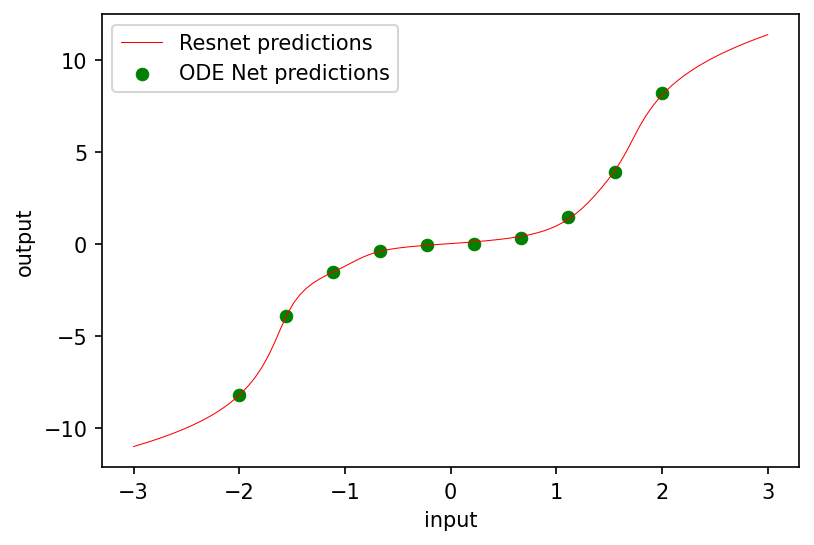

In [16]:
# Toy 1D dataset.
inputs = jnp.reshape(jnp.linspace(-2.0, 2.0, 10), (10, 1))
targets = inputs**3 + 0.1 * inputs


param_scale = 1.0
step_size = 0.01
train_iters = 1000

# We need to change the input dimension to 2, to allow time-dependent dynamics.
odenet_layer_sizes = [2, 20, 1]

def odenet_loss(params, inputs, targets):
  preds = batched_odenet(params, inputs)
  return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

@jit
def odenet_update(params, inputs, targets):
  grads = grad(odenet_loss)(params, inputs, targets)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

# Initialize and train ODE-Net.
odenet_params = init_random_params(param_scale, odenet_layer_sizes)

for i in range(train_iters):
  odenet_params = odenet_update(odenet_params, inputs, targets)

# Plot resulting model.
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))

ax.plot(fine_inputs, batched_odenet(odenet_params, fine_inputs), lw=0.5, color='red')
ax.set_xlabel('input')
ax.set_ylabel('output')
plt.legend(('Resnet predictions', 'ODE Net predictions'))